# 7. Harris Edge & Corner Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Color image to Grayscale conversion](#grayscale)
3. [Spatial derivative calculation](#spatial)
4. [Structure tensor setup](#tensor)
5. [Harris response calculation](#response)
6. [Find edges and corners using R](#find)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage.filters import convolve

<ipython-input-1-2a3762aac77b>:5: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Color to Grayscale <a class="anchor" id="grayscale" ></a>

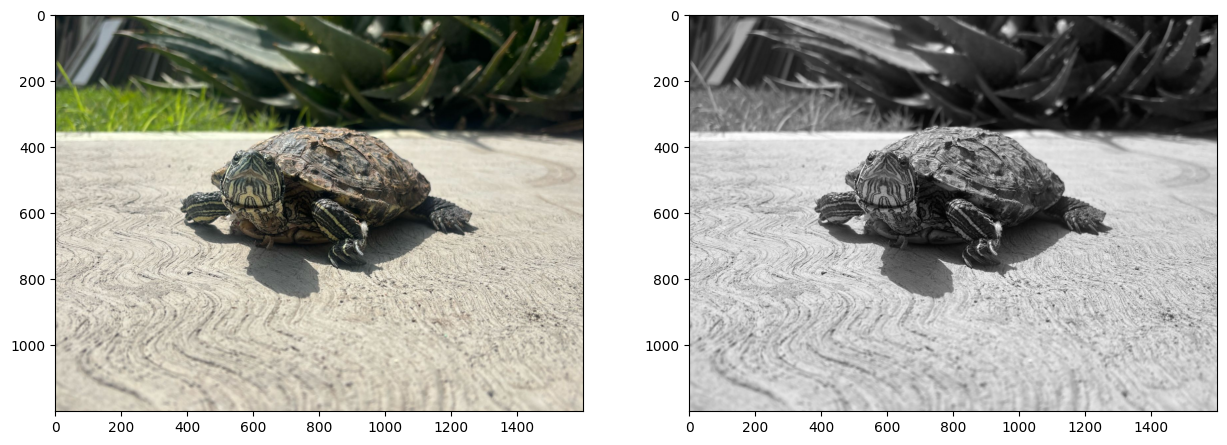

In [3]:
img = cv2.imread('/content/drive/MyDrive/VisionComp_Imagenes/data/tortu_1.jpeg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 2. Spatial derivative calculation <a class="anchor" id="spatial" ></a>

In [4]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

## 3. Structure tensor setup <a class="anchor" id="tensor" ></a>

In [5]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

## 4. Harris response calculation <a class="anchor" id="response" ></a>

In [6]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy

harris_response = detA - k * traceA ** 2

In [7]:
img_gray.shape

(1200, 1600)

In [8]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [9]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

## 5. Find edges and corners using R <a class="anchor" id="find" ></a>

In [10]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

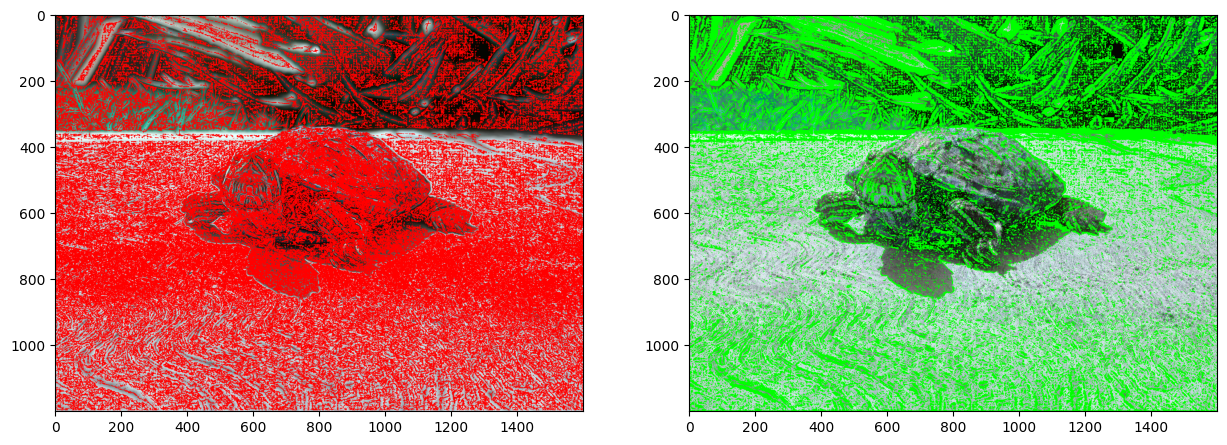

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

Meh! Imagenes no tan buenas hay que detectar los bordes o por el contrario se detectan demasiados bordes. Esto no nos ayuda mucho así que tendremos que aplicar diferentes métodos para mejorar nuestras imagenes.

# Algoritmo de Harris Corner Detection

El algoritmo de **Harris Corner Detection** es un método utilizado en visión por computadora para detectar esquinas en imágenes. Una esquina se define como un punto donde hay un cambio significativo en la intensidad en múltiples direcciones.

## **Fórmula matemática**
El algoritmo se basa en la matriz de estructura de la imagen:

\[
$M = \sum_{x,y}$
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
\]

Donde:
- \( $I_x$ \) y \( $I_y$ \) son las derivadas de la imagen en las direcciones **x** e **y**, respectivamente.
- Se aplica un filtro Gaussiano a la matriz para suavizar la imagen.

El valor de respuesta de Harris se calcula como:

\[
$R = det(M) - k (trace(M))^2$
\]

Donde:
- \( $det(M) = I_x^2 I_y^2 - (I_x I_y)^2$ \) es el determinante de la matriz.
- \( $trace(M) = I_x^2 + I_y^2$ \) es la traza de la matriz.
- \( $k$ \) es un parámetro de sensibilidad, típicamente en el rango \( $0.04 \leq k \leq 0.06$ \).

## **Ventajas**
- Detecta esquinas de manera eficiente.
- Invariante a rotación.
- Robusto en presencia de ruido si se ajustan los parámetros correctamente.

## **Desventajas**
- No es invariante a cambios de escala.
- Sensible a cambios en la iluminación y al ruido si no se preprocesa la imagen adecuadamente.
- Puede generar múltiples respuestas para una misma esquina, requiriendo un posprocesamiento para filtrar los puntos redundantes.
"""


## Contexto de las imagenes a analizar.
Una vez que ya hemos visto un poco sobre que trata el algoritmo de Harris. Podemos empezar a plantear y testear el algoritmo en diferentes imagenes.

Las imagenes a analizar son fotografias tomadas de mi Tortuga mascota el día 15 de Febrero de 2025. Fueron tomadas el medio día usando mi celular.

Las imagenes presentaran retos como veremos más adelante porque son fotografias en diferentes angulos, algunas tomadas en el patio, otras tomadas en el interior de la casa, unas con exposicion al sol y otras en la sonbra al interior de la casa. Al ser un animal vivo es imposible que permanezca estatico, lo cual significa un reto al usar el método porque las posturas serán diferentes.

A continuación se despliegan las imagenes:

In [14]:
# Crgamos las imagenes
my_img1= cv2.imread('/content/drive/MyDrive/VisionComp_Imagenes/data/tortu_1.jpeg')
my_img2= cv2.imread('/content/drive/MyDrive/VisionComp_Imagenes/data/tortu_2.jpeg')
my_img3= cv2.imread('/content/drive/MyDrive/VisionComp_Imagenes/data/tortu_3.jpeg')
my_img4= cv2.imread('/content/drive/MyDrive/VisionComp_Imagenes/data/tortu_4.jpeg')
my_img5= cv2.imread('/content/drive/MyDrive/VisionComp_Imagenes/data/tortu_5.jpeg')
my_img6= cv2.imread('/content/drive/MyDrive/VisionComp_Imagenes/data/tortu_6.jpeg')

images = [my_img1, my_img2, my_img3, my_img4, my_img5, my_img6]

# Transformamos en tipo float 32, descubrimos que con esta transformación se aplica mejor el método.
for i in range(len(images)):
  images[i] = images[i].astype(np.float32)
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)

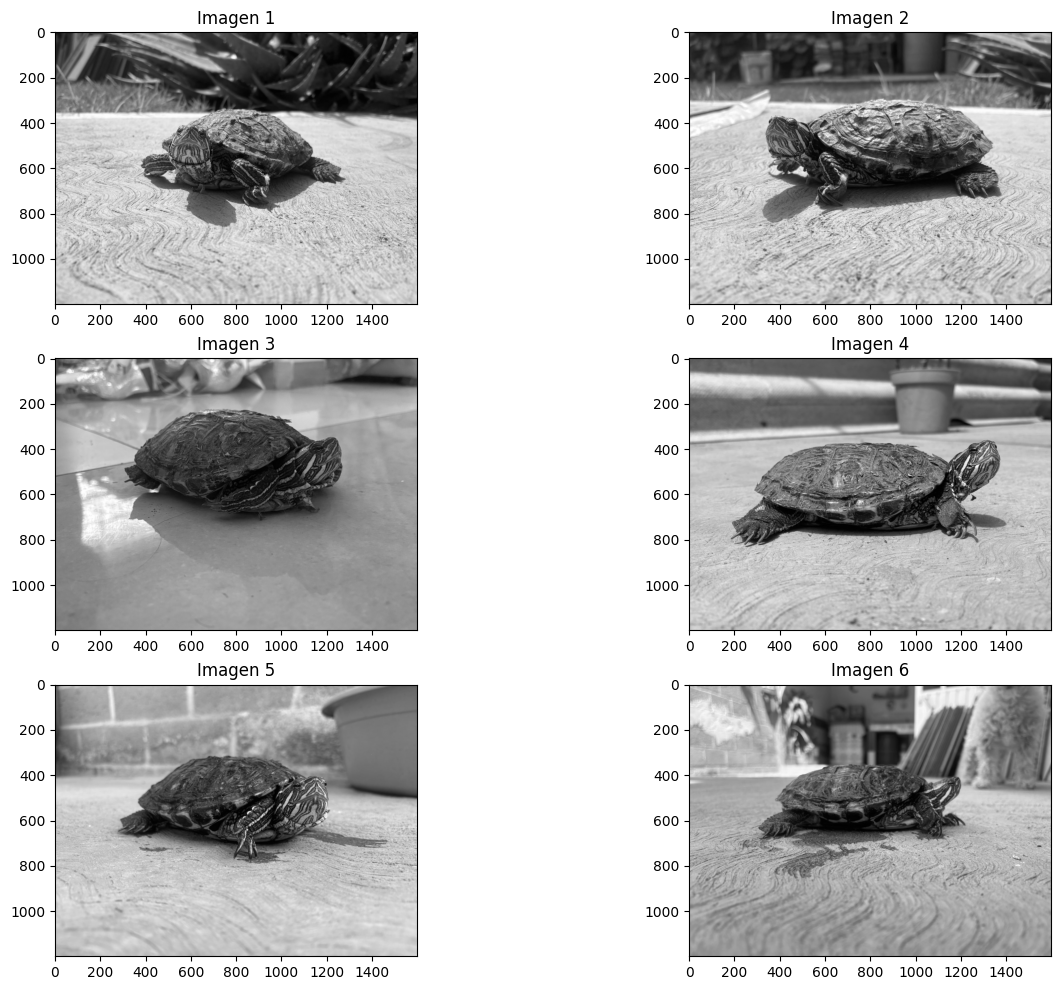

In [15]:
# Imprimimos las imagenes visualizandolas
plt.figure(figsize=(15, 12))
for i, img in enumerate(images):
  plt.subplot(3, 2, i+1)
  plt.imshow(images[i], cmap="gray")
  plt.title(f"Imagen {i+1}")

# Función `cv2.cornerHarris`

La función `cv2.cornerHarris` es la implementación en OpenCV del detector de esquinas de Harris.

## **Sintaxis**
```python
cv2.cornerHarris(src, blockSize, ksize, k)
```

## **Parámetros**
- `src`: Imagen de entrada en escala de grises (tipo `float32`).
- `blockSize`: Tamaño del vecindario considerado para la detección de esquinas.
- `ksize`: Tamaño del kernel de Sobel utilizado para calcular las derivadas.
- `k`: Parámetro libre de la ecuación de Harris, típicamente en el rango `0.04 - 0.06`.


## Uso de la función en este analísis.

Realizamos una exploración de nuestras imagenes adicional a la que proporciona el código originalmente.

Para esto hacemos uso de la función `cv2.cornerHarris` variando diferentes parámetros de esta función según la imagen a analízar para obtenr la mejor aproximación y detección de bordes.

## Imagen 1.
`Contexto de captura de imagen:` Fotografía tomada en el patio bajo el sol. Se toma una fotografía de enfrente.


In [18]:
def detect_harris_corners(blocksize, ksize, k, h_img):
    # Aplicar Harris Corner Detection
    dst = cv2.cornerHarris(h_img, blocksize, ksize, k)

    # Dilatación y normalización de resultados
    dst_norm = cv2.dilate(dst, None)

    # Umbral para la creación de keypoints
    threshold = 0.03 * dst_norm.max()
    keypoints = []

    # Crear los keypoints según el umbral
    for i in range(dst_norm.shape[0]):
        for j in range(dst_norm.shape[1]):
            if dst_norm[i, j] > threshold:
                keypoints.append(cv2.KeyPoint(j, i, 1))

    # Dibujar keypoints en la imagen
    img_with_keypoints = cv2.drawKeypoints(h_img.astype(np.uint8), keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Mostrar la imagen con plt
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return plt

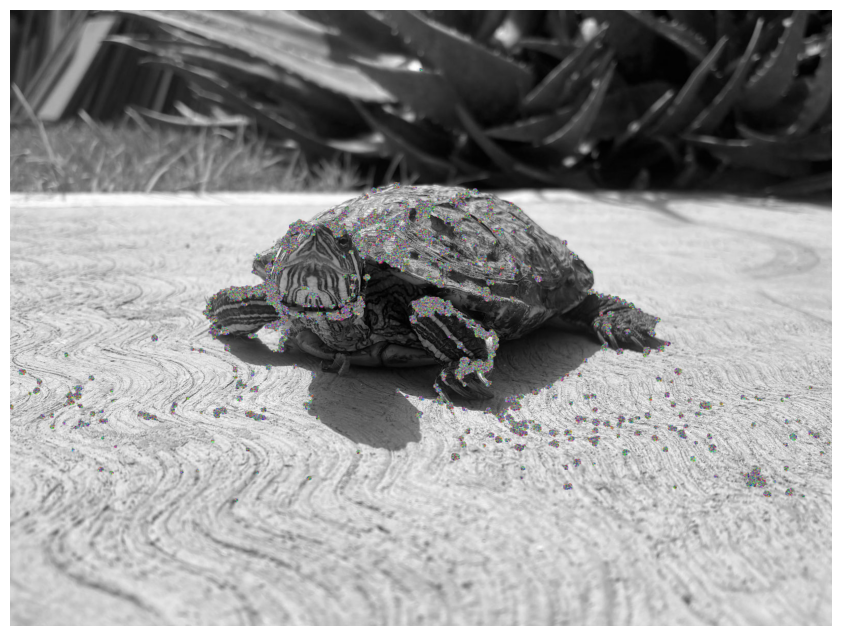

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [19]:
detect_harris_corners(8, 7, 0.06, images[0])

**Comentarios:** Observamos que si se detectan bordes adecuadamente como en el cuello de la tortuga y aprte de su pie y el caparazon, pero el ruido de la imagen puede aceptar. El piso de ocncreto es igual detectado como bordes. Hay que tener cuidado con eso dependiendo el resultado final esperado.

## Imagen 2
`Contexto de captura de imagen:` Imagen tomada en el patio bajo el sol con buena iluminación desde otro ángulo diferente.

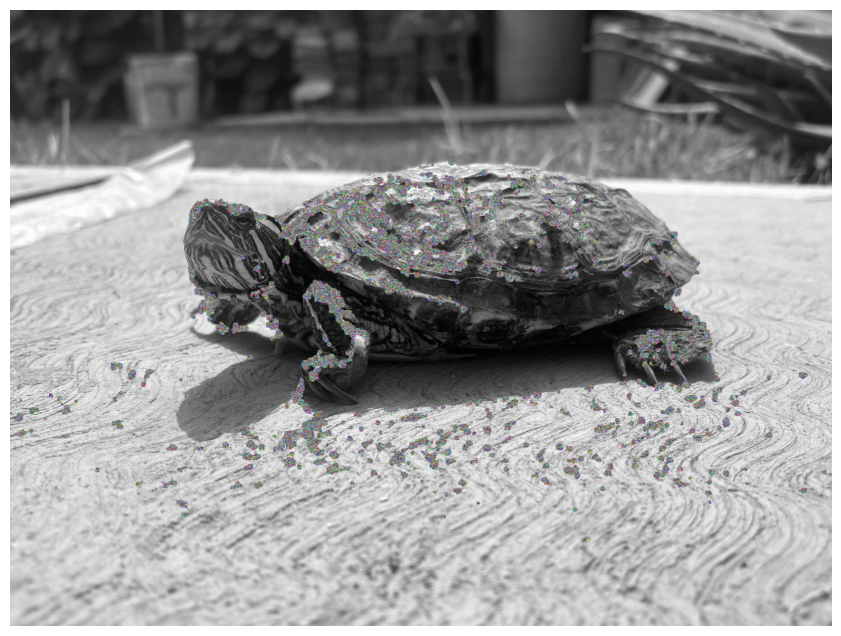

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [26]:
detect_harris_corners(8, 7, 0.04, images[1])

**Comentarios:** Resultado similar a la anterior imagen pues se alcanzan a apreciar los puntos de contorno en el caparazón de la tortuga, pero se estan resaltando igual puntos en el concreto y ese es un resultado que no se esperaba.

## Imagen 3
`Contexto de captura de imagen:` Imagen tomada desde dentro de la casa, bajo la sombra. Foto tomada desde el costado.

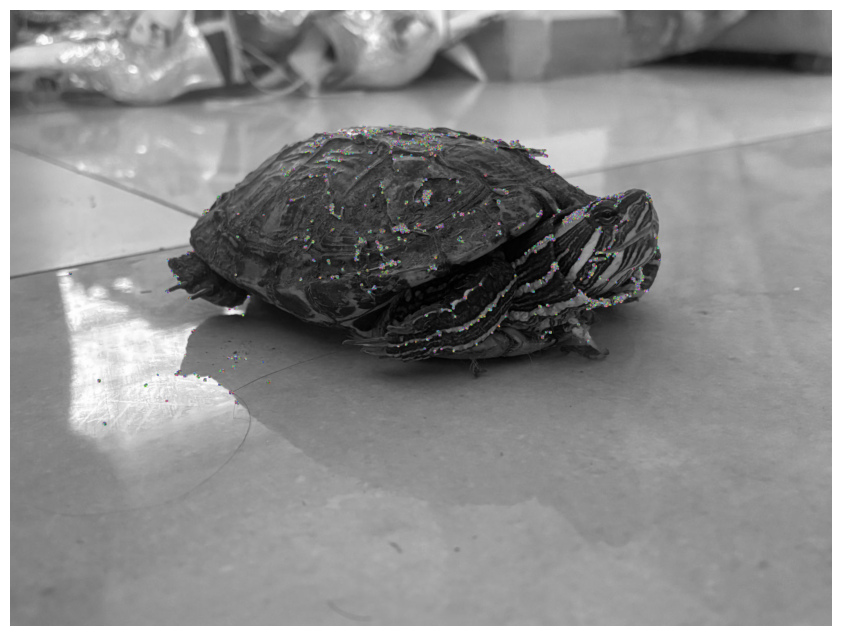

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [27]:
detect_harris_corners(3, 1, 0.04, images[2])

**Comentarios:** Al ser ahora una imagen tomada en el interior de la casa, la intensidad de la luz es menor al haber sombra, el tipo de piso igual ha cambiado a azulejo por lo que ya no tenemos el resultado de las imagenes anteriores de que detectara bordes ahí. Esta imagen es la que mejor presenta diferencia con el contorno de la tortuga y su caparazón.

## Imagen 4
`Contexto de captura de imagen:` Imagen tomada en el patio, bajo el sol y de costado, con otra posición distinta.

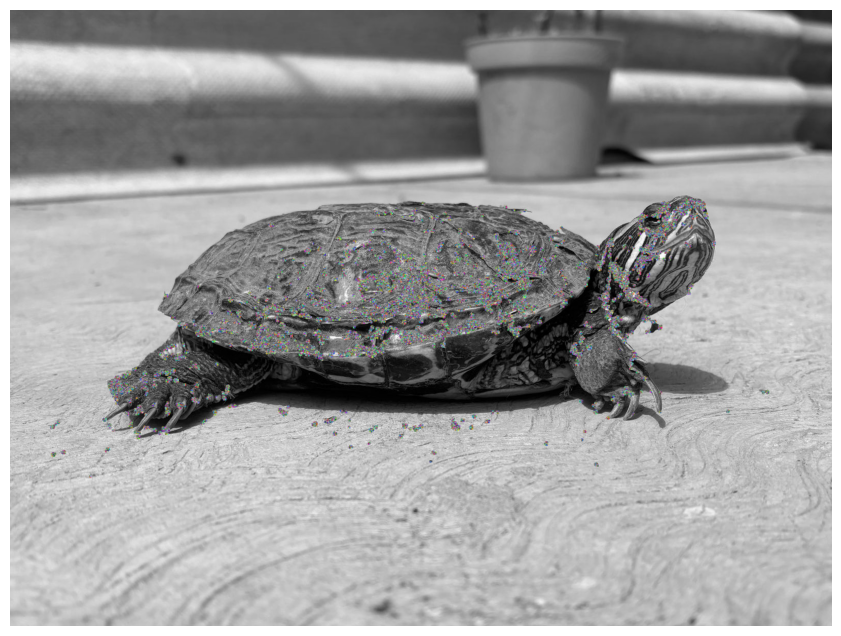

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [28]:
detect_harris_corners(5, 3, 0.06, images[3])

**Comentarios:** Imagen que vuelve a ser tomada en el exterior de la casa. Esta imagen al ser de perfil el resultado se pierde en el caparazón lo cual hace que el resultado sea pobre. En la cabeza se alcanza a distinguir los puntos de la detección de puntos.

## Imagen 5
`Contexto de captura de imagen:` Imagen tomada en el patio, del lado de la sombra por lo que la exposición a la luz es mucho menor en una posición de enfrente.

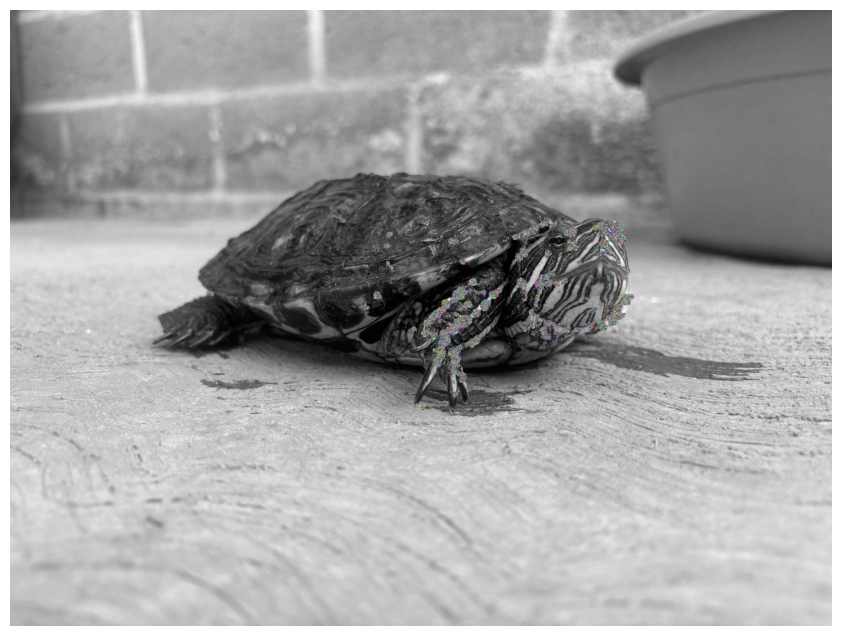

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [29]:
detect_harris_corners(10, 9, 0.07, images[4])

**Comentarios:** Imagen que es tomada en la sombra en el exterior, observemos que lso puntos son mucho menos en comapración de las fotos tomadas en el exterior. El resultado es bueno porque se detectan rasgos de la cara, la garra y el cuello.

## Imagen 6
`Contexto de captura de imagen:` Imagen tomada en el patio, bajo la sobra en una posición de costado.

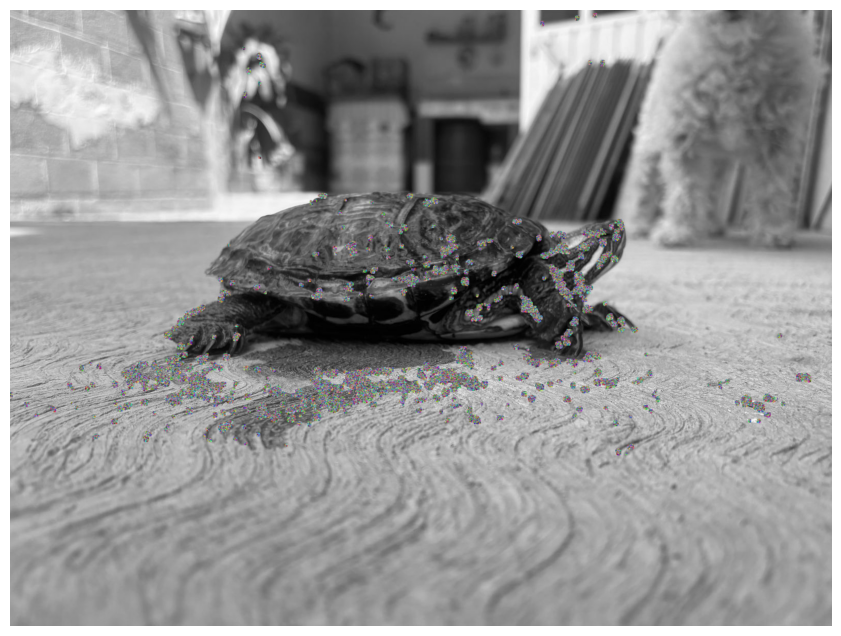

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [30]:
detect_harris_corners(10, 7, 0.06, images[5])

**Comentarios:** A diferencia de la anterior fotografí a tomada de costado en esta imagen se alcanzan a apreciar mucho mejor la estructura de puntos detectados en el caparazón así como la cara. Diferentes ángulos de un mismo objeto reproducen resultados diferentes, consideramos que además la imagen fue tomada bajo el agua.

Adicional, hay un charco de agua abajo este también es detectado con bordes así que el contecto o resto de ruido en las imagenes cuenta mucho.

# Conclusiones:
Observemos que el método logra efectuarse en las diferentes imagenes con diferente intensidad, ha dependido mucho de la variación de los parámetros aplicados y la calidad de la imagen o la posición algo a destacar es que no solo nuestros objetos deseados van a ser suceptibles al método aplicado, sino que también serán detectados los bordes y toda la inforamción en el contorno.
